## Baseline for the vanilla federated learning approach using FedAvg

In [1]:
import numpy as np
import wandb
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
import shutil
import os                              # Import the 'os' module for changing directories
os.chdir('/content/drive/MyDrive/BRISC2025_FL')  # Change the directory

Mounted at /content/drive


In [15]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Render plots inline
%matplotlib inline

BASE_DIR = "data/brisc2025/"

In [16]:
# In[2] — Directory Tree
def walk_dir(base, max_depth=2):
    for root, dirs, _ in os.walk(base):
        depth = root.replace(base, "").count(os.sep)
        if depth <= max_depth:
            indent = "  " * depth
            print(f"{indent}{os.path.basename(root)}/")
            for d in dirs:
                print(f"{indent}  {d}/")

print("## BRISC2025 Folder Layout:")
walk_dir(BASE_DIR, max_depth=2)

## BRISC2025 Folder Layout:
/
  segmentation_task/
  classification_task/
segmentation_task/
  test/
  train/
  test/
    masks/
    images/
    masks/
    images/
  train/
    images/
    masks/
    images/
    masks/
classification_task/
  train/
  test/
  train/
    no_tumor/
    glioma/
    pituitary/
    meningioma/
    no_tumor/
    glioma/
    pituitary/
    meningioma/
  test/
    no_tumor/
    meningioma/
    pituitary/
    glioma/
    no_tumor/
    meningioma/
    pituitary/
    glioma/


In [46]:
# File Count Logic (no need to change if BASE_DIR is fixed)
def count_patterns(patterns):
    return sum(len(glob.glob(p)) for p in patterns)

# Classification
splits = ["test", "train"]
classes = ["glioma", "meningioma", "pituitary", "no_tumor"]
cls_records = []
for sp in splits:
    total = 0
    for cls in classes:
        pat = os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg")
        cnt = count_patterns([pat])
        cls_records.append({'Split': sp, 'Class': cls, 'Count': cnt})
        total += cnt
    cls_records.append({'Split': sp, 'Class': 'Total', 'Count': total})
df_cls = pd.DataFrame(cls_records)

# Display
print("### Classification Counts")
display(df_cls)

### Classification Counts


,Split,Class,Count
0,test,glioma,254
1,test,meningioma,306
2,test,pituitary,300
3,test,no_tumor,140
4,test,Total,1000
5,train,glioma,1147
6,train,meningioma,1329
7,train,pituitary,1457
8,train,no_tumor,1067
9,train,Total,5000


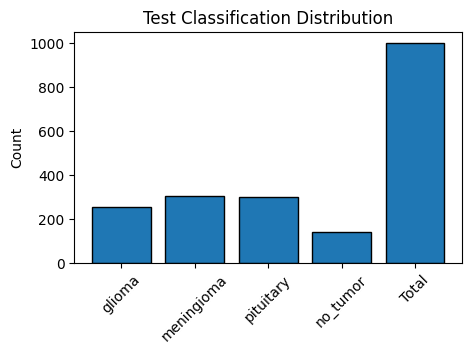

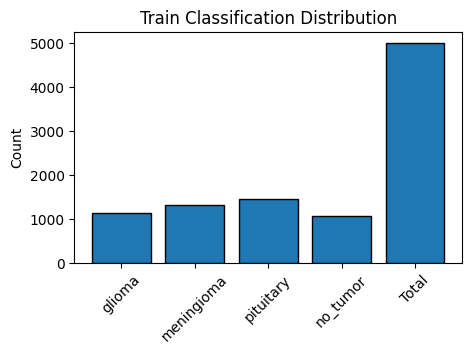

In [47]:
# In[4] — Distribution Plots
for sp in splits:
    sub = df_cls[df_cls.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Class, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Classification Distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

An important feature of this dataset is the inclusion of multi-
ple imaging perspectives for each tumor, covering the
Coronal, Sagittal, and Axial planes. This comprehensive approach captures a diverse range of tumor char-
acteristics, enabling researchers to train models that
generalize well across different views.

In [48]:
# In[5] — Per‑Plane Counts
planes = ["ax", "co", "sa"]
plane_records = []

for sp in splits:
    for cls in classes:
        for pl in planes:
            pat = os.path.join(
                BASE_DIR, "classification_task", sp, cls, f"*_{pl}_t1.jpg"
            )
            cnt = count_patterns([pat])
            plane_records.append({'Split': sp, 'Class': cls, 'Plane': pl, 'Count': cnt})

df_plane = pd.DataFrame(plane_records)
print("### Per‑Plane Counts Pivot")
display(df_plane.pivot_table(index='Plane', columns=['Split','Class'], values='Count'))

### Per‑Plane Counts Pivot


Split   test                                train                      \
Class glioma meningioma no_tumor pituitary glioma meningioma no_tumor   
Plane                                                                   
ax      85.0      137.0     52.0     124.0  394.0      423.0    352.0   
co      81.0       86.0     48.0      90.0  430.0      426.0    310.0   
sa      88.0       83.0     40.0      86.0  323.0      480.0    405.0   

Split            
Class pituitary  
Plane            
ax        426.0  
co        510.0  
sa        521.0

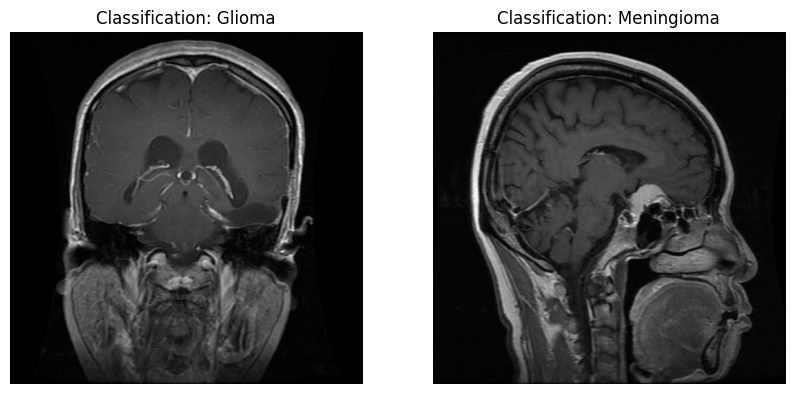

In [50]:
# In[6] — Sample Visualization
def first_file(folder, exts):
    for ext in exts:
        fl = glob.glob(os.path.join(folder, f"*.{ext}"))
        if fl: return fl[0]
    return None

img_path  = first_file(os.path.join(BASE_DIR, "classification_task/train/glioma"), ["jpg"])
img2_path = first_file(os.path.join(BASE_DIR, "classification_task/train/meningioma"), ["jpg"])
img  = Image.open(img_path)
img2 = Image.open(img2_path)


fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(img,  cmap="gray"); axes[0].set_title("Classification: Glioma"); axes[0].axis("off")
axes[1].imshow(img2,  cmap="gray"); axes[1].set_title("Classification: Meningioma"); axes[1].axis("off")

plt.show()

In [57]:
# In[8] — Metadata Table
meta = []
for sp in splits:
    for cls in classes:
        files = glob.glob(os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg"))[:1]
        for f in files:
            parts = os.path.basename(f).split("_")
            meta.append({
                "Filename": os.path.basename(f),
                "Split": parts[1],
                "Index": parts[2],
                "Tumor": parts[3],
                "Plane": parts[4],
                "Sequence": parts[5].split(".")[0]
            })
df_meta = pd.DataFrame(meta)
print("### Sample Filename Metadata")
display(df_meta)

### Sample Filename Metadata


,Filename,Split,Index,Tumor,Plane,Sequence
0,brisc2025_test_00079_gl_ax_t1.jpg,test,00079,gl,ax,t1
1,brisc2025_test_00481_me_sa_t1.jpg,test,00481,me,sa,t1
2,brisc2025_test_00960_pi_sa_t1.jpg,test,00960,pi,sa,t1
3,brisc2025_test_00666_no_sa_t1.jpg,test,00666,no,sa,t1
4,brisc2025_train_00713_gl_co_t1.jpg,train,00713,gl,co,t1
5,brisc2025_train_02287_me_sa_t1.jpg,train,02287,me,sa,t1
6,brisc2025_train_04172_pi_co_t1.jpg,train,04172,pi,co,t1
7,brisc2025_train_03422_no_sa_t1.jpg,train,03422,no,sa,t1


In [72]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Example: pick the row for a specific filename
row = df_meta[df_meta['Filename'] == "brisc2025_test_00079_gl_ax_t1.jpg"].iloc[0]

# Build the full path
img_path = os.path.join(BASE_DIR, "classification_task", row['Split'], row['Tumor'], row['Filename'])

# Open and display the image
img = Image.open(img_path)

plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
plt.title(f"Tumor: {row['Tumor'].capitalize()}, Plane: {row['Plane']}")
plt.axis("off")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'data/brisc2025/classification_task/test/gl/brisc2025_test_00079_gl_ax_t1.jpg'